# Streetcar Delay Prediction - Deep Learning

GOAL: predict streetcar delays using a simple Keras model

Source dataset: : https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da

# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#definecategories>Define feature categories</a>

<a href=#bookmark>Deal with missing values</a>

<a href=#modelfit>Define and fit model</a>

<a href=#reload>Reload saved model and weights</a>

<a href=#confusionmatrix>Confusion matrix</a>

In [277]:
# libraries that had to explicitly installed for Paperspace Gradient
!pip install sklearn
!pip install seaborn
!pip install keras
!pip install tensorflow
!pip install pydot

In [278]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import datetime
import os
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
import pydot
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# from sklearn.preprocessing import CategoricalEncoder

# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math
from subprocess import check_output
import seaborn as sns

#model libraries


from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import backend as K
from keras.utils.vis_utils import plot_model


In [279]:
# set overall parameters

dsxmode = False # overall is this being run in DSX?
csvmode = True # ingest from CSV
dbmode = False # ingest from database
pSpace = True # pSpace mode
savepath = '/home/paperspace/models/'
readpath = '/home/paperspace/data/dmprediction/'

testproportion = 0.01 # proportion of data reserved for test set
trainproportion = 0.8 # proportion of non-test data dedicated to training (vs. validation)
verboseout = True
includetext = True # switch to determine whether text fields are included in model
presaved = False # switch to determine whether to train model or load saved model
savemodel = True # switch to determine whether to save model
picklemodel = True # switch for code to allow pickling of Keras model
sphereworld = True
hctextmax = 7000
maxwords = 6000

# threshold between 0 and 1 target for regression target
targetthresh = 5.0
targetcontinuous = False # switch to determine whether target is continuous or 

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}

#time_of_day = {'overnight':[0,5],'morning_rush':[5,10],
 #             'midday':[10,15],'aft_rush':[15,19],'evening':[19,23]}
              


emptythresh = 6000
# to address imbalance in training data between zero (above targetthresh) and detractor (below targetthresh) specify weight in compile and fit
# class_weight = {0 : zero_weight, 1: one_weight}
# consider calculating these values from actual skew rather than hard-coding them here
zero_weight = 1.0
one_weight = 72.8

# hyperparameters
learning_rate = 0.001
dropout_rate = 0.0003 #0.003
l2_lambda = 0.0003 #7.5
loss_func = "binary_crossentropy"
if targetcontinuous:
    output_activation = "linear"
else:
    output_activation = "hard_sigmoid"



In [280]:
# get the directory for that this notebook is in
rawpath = os.getcwd()
print("raw path is",rawpath)

raw path is /storage/manning/notebooks


In [281]:
# data is in a directory called "data" that is a sibling to the directory containing the notebook
path = os.path.abspath(os.path.join(rawpath, '..', 'data')) + "/"
print("path is", path)

path is /storage/manning/data/


In [282]:
# time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
#              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':23}}
              

def get_time(hour):
    for tod in time_of_day:
        if (hour >= time_of_day[tod]['start']) and (hour < time_of_day[tod]['end']):
            tod_out = tod
    return(tod_out)

def weekend_time(day, tod):
    if (day=='Saturday') or (day=='Sunday'):
        return('w'+tod)
    else:
        return(tod)
            
            

In [283]:
print("tod on",time_of_day['overnight']['start'])

tod on 0


In [284]:
print("tod  0",get_time(0))
print("tod 5",get_time(23))

tod  0 overnight
tod 5 evening


In [285]:
# constants for the streetcar problem
# same values saved in data_preparation notebook: pickled_input_dataframe, pickled_output_dataframe
pickled_data_file = '2014_2018.pkl'
#pickled_dataframe = '2014_2018_df.pkl'
pickled_dataframe = '2014_2018_df_cleaned_keep_bad_loc_geocoded_SCtrimmed_apr26.pkl'

# Ingest data <a name='ingestdash' />
<a href=#linkanchor>Back to link list</a>

In [286]:
file_name = path + pickled_dataframe
merged_data = pd.read_pickle(file_name)
merged_data.head()

,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,lat_long,latitude,longitude
1,1,2016-01-01 00:00:00,511,02:14:00,Friday,fleet st. and strachan,Mechanical,10.0,20.0,e,4018,2016-01-01 02:14:00,"[43.6362976, -79.4096351]",43.636298,-79.409635
2,2,2016-01-01 00:00:00,301,02:22:00,Friday,queen st. west and roncesvalles,Mechanical,9.0,18.0,w,4201,2016-01-01 02:22:00,"[43.64533489999999, -79.4131843]",43.645335,-79.413184
3,3,2016-01-01 00:00:00,301,03:28:00,Friday,lake shore blvd. and superior st.,Mechanical,20.0,40.0,e,4251,2016-01-01 03:28:00,"[43.61496169999999, -79.4886581]",43.614962,-79.488658
5,5,2016-01-01 00:00:00,505,15:42:00,Friday,broadview station loop,Investigation,4.0,10.0,w,4187,2016-01-01 15:42:00,"[43.677135, -79.35820799999999]",43.677135,-79.358208
6,6,2016-01-01 00:00:00,504,15:54:00,Friday,broadview and queen,Mechanical,6.0,12.0,e,4181,2016-01-01 15:54:00,"[43.6593626, -79.34769709999999]",43.659363,-79.347697


In [287]:
merged_data['latitude'].max()

43.687496

In [288]:
merged_data['latitude'].min()

43.588203799999995

In [289]:
merged_data['longitude'].min()

-79.54626379999998

In [290]:
merged_data['longitude'].max()

-79.28135040000001

In [291]:
long_mean = merged_data['longitude'].mean()

In [292]:
lat_mean = merged_data['latitude'].mean()

In [293]:
merged_data.shape

(65049, 15)

In [294]:
if sphereworld:
    # use approach described here https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature
    # x = cos(lat) * cos(lon)
    # y = cos(lat) * sin(lon), 
    # z = sin(lat) 
    merged_data['x'] = np.cos(merged_data['latitude']) * np.cos(merged_data['longitude'])
    merged_data['y'] = np.cos(merged_data['latitude']) * np.sin(merged_data['longitude'])
    merged_data['z'] = np.sin(merged_data['latitude'])
    x_mean = merged_data['x'].mean()
    y_mean = merged_data['y'].mean()
    z_mean = merged_data['z'].mean()
    merged_data['x'] = merged_data['x'] / x_mean
    merged_data['y'] = merged_data['y'] / y_mean
    merged_data['z'] = merged_data['z'] / z_mean    
else:    
    merged_data['longitude'] = merged_data['longitude']/long_mean
    merged_data['latitude'] = merged_data['latitude']/lat_mean

In [295]:
merged_data.head(20)

,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,lat_long,latitude,longitude,x,y,z
1,1,2016-01-01 00:00:00,511,02:14:00,Friday,fleet st. and strachan,Mechanical,10.0,20.0,e,4018,2016-01-01 02:14:00,"[43.6362976, -79.4096351]",43.636298,-79.409635,0.977464,1.008331,1.052572
2,2,2016-01-01 00:00:00,301,02:22:00,Friday,queen st. west and roncesvalles,Mechanical,9.0,18.0,w,4201,2016-01-01 02:22:00,"[43.64533489999999, -79.4131843]",43.645335,-79.413184,0.976479,1.014598,1.026142
3,3,2016-01-01 00:00:00,301,03:28:00,Friday,lake shore blvd. and superior st.,Mechanical,20.0,40.0,e,4251,2016-01-01 03:28:00,"[43.61496169999999, -79.4886581]",43.614962,-79.488658,0.875994,1.063870,1.114623
5,5,2016-01-01 00:00:00,505,15:42:00,Friday,broadview station loop,Investigation,4.0,10.0,w,4187,2016-01-01 15:42:00,"[43.677135, -79.35820799999999]",43.677135,-79.358208,1.050088,0.976627,0.932493
6,6,2016-01-01 00:00:00,504,15:54:00,Friday,broadview and queen,Mechanical,6.0,12.0,e,4181,2016-01-01 15:54:00,"[43.6593626, -79.34769709999999]",43.659363,-79.347697,1.055709,0.961398,0.984954
9,9,2016-01-01 00:00:00,510,16:34:00,Friday,richmond st. and spadina,Diversion,41.0,46.0,s,bad vehicle,2016-01-01 16:34:00,"[43.6478469, -79.39588049999999]",43.647847,-79.395880,0.997371,1.000613,1.018781
11,11,2016-01-01 00:00:00,505,17:36:00,Friday,dundas st. west and huron st.,Held By,7.0,13.0,w,4039,2016-01-01 17:36:00,"[43.653332, -79.3961386]",43.653332,-79.396139,0.998960,1.002730,1.002685
12,12,2016-01-01 00:00:00,506,19:15:00,Friday,bathurst and college,Utilized Off Route,7.0,14.0,w,4095,2016-01-01 19:15:00,"[43.6564647, -79.4077012]",43.656465,-79.407701,0.986625,1.013797,0.993479
13,13,2016-01-01 00:00:00,509,21:25:00,Friday,cne loop,Mechanical,10.0,20.0,e,4406,2016-01-01 21:25:00,"[43.63441590000001, -79.4258807]",43.634416,-79.425881,0.957869,1.021327,1.058064
14,14,2016-01-01 00:00:00,511,22:54:00,Friday,bathurst and wellington,Held By,16.0,24.0,b,4095,2016-01-01 22:54:00,"[43.6426297, -79.4021618]",43.642630,-79.402162,0.988324,1.004210,1.034063


In [296]:
# define cols for year month day
# apar_ds["year"] = pd.DatetimeIndex(apar_ds['PMR_Open_Date']).year 
merged_data['year'] = pd.DatetimeIndex(merged_data['Report Date']).year
merged_data['month'] = pd.DatetimeIndex(merged_data['Report Date']).month
merged_data['daym'] = pd.DatetimeIndex(merged_data['Report Date']).day
merged_data.head()

,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,...,Report Date Time,lat_long,latitude,longitude,x,y,z,year,month,daym
1,1,2016-01-01 00:00:00,511,02:14:00,Friday,fleet st. and strachan,Mechanical,10.0,20.0,e,...,2016-01-01 02:14:00,"[43.6362976, -79.4096351]",43.636298,-79.409635,0.977464,1.008331,1.052572,2016,1,1
2,2,2016-01-01 00:00:00,301,02:22:00,Friday,queen st. west and roncesvalles,Mechanical,9.0,18.0,w,...,2016-01-01 02:22:00,"[43.64533489999999, -79.4131843]",43.645335,-79.413184,0.976479,1.014598,1.026142,2016,1,1
3,3,2016-01-01 00:00:00,301,03:28:00,Friday,lake shore blvd. and superior st.,Mechanical,20.0,40.0,e,...,2016-01-01 03:28:00,"[43.61496169999999, -79.4886581]",43.614962,-79.488658,0.875994,1.063870,1.114623,2016,1,1
5,5,2016-01-01 00:00:00,505,15:42:00,Friday,broadview station loop,Investigation,4.0,10.0,w,...,2016-01-01 15:42:00,"[43.677135, -79.35820799999999]",43.677135,-79.358208,1.050088,0.976627,0.932493,2016,1,1
6,6,2016-01-01 00:00:00,504,15:54:00,Friday,broadview and queen,Mechanical,6.0,12.0,e,...,2016-01-01 15:54:00,"[43.6593626, -79.34769709999999]",43.659363,-79.347697,1.055709,0.961398,0.984954,2016,1,1


In [297]:
# get the record count by year
merged_data["year"].value_counts()

2018    14524
2016    13072
2017    12755
2015    11537
2014    10358
2019     2803
Name: year, dtype: int64

In [298]:
# get record count by year by month
merged_data.groupby(["year", "month"]).size()

year  month
2014  1         307
      2         170
      3        1165
      4        1110
      5         897
      6        1107
      7         956
      8         975
      9        1097
      10        934
      11        813
      12        827
2015  1        1183
      2        1611
      3        1012
      4         886
      5         795
      6         936
      7         838
      8         915
      9        1095
      10        864
      11        712
      12        690
2016  1        1107
      2        1042
      3        1136
      4        1066
      5         985
      6        1016
               ... 
      9         972
      10       1087
      11       1311
      12       1415
2017  1        1209
      2        1050
      3        1050
      4         961
      5        1163
      6        1094
      7         878
      8         827
      9         874
      10        946
      11       1087
      12       1616
2018  1        1539
      2        1223
      3 

In [299]:
# define cols for time of day
merged_data['hour'] = pd.DatetimeIndex(merged_data['Report Date Time']).hour
merged_data.head()

,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,...,lat_long,latitude,longitude,x,y,z,year,month,daym,hour
1,1,2016-01-01 00:00:00,511,02:14:00,Friday,fleet st. and strachan,Mechanical,10.0,20.0,e,...,"[43.6362976, -79.4096351]",43.636298,-79.409635,0.977464,1.008331,1.052572,2016,1,1,2
2,2,2016-01-01 00:00:00,301,02:22:00,Friday,queen st. west and roncesvalles,Mechanical,9.0,18.0,w,...,"[43.64533489999999, -79.4131843]",43.645335,-79.413184,0.976479,1.014598,1.026142,2016,1,1,2
3,3,2016-01-01 00:00:00,301,03:28:00,Friday,lake shore blvd. and superior st.,Mechanical,20.0,40.0,e,...,"[43.61496169999999, -79.4886581]",43.614962,-79.488658,0.875994,1.063870,1.114623,2016,1,1,3
5,5,2016-01-01 00:00:00,505,15:42:00,Friday,broadview station loop,Investigation,4.0,10.0,w,...,"[43.677135, -79.35820799999999]",43.677135,-79.358208,1.050088,0.976627,0.932493,2016,1,1,15
6,6,2016-01-01 00:00:00,504,15:54:00,Friday,broadview and queen,Mechanical,6.0,12.0,e,...,"[43.6593626, -79.34769709999999]",43.659363,-79.347697,1.055709,0.961398,0.984954,2016,1,1,15


In [300]:
# define time of day column
merged_data['time_of_day'] = merged_data['hour'].apply(lambda x:get_time(x))
merged_data.head()

# add a special timeframe for weekends
# df['NewCol'] = df.apply(lambda x: segmentMatch(x['TimeCol'], x['ResponseCol']), axis=1)
# weekend_time(day, tod)
merged_data['time_of_day'] = merged_data.apply(lambda x: weekend_time(x['Day'], x['time_of_day']), axis=1)
merged_data.head()

,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,...,latitude,longitude,x,y,z,year,month,daym,hour,time_of_day
1,1,2016-01-01 00:00:00,511,02:14:00,Friday,fleet st. and strachan,Mechanical,10.0,20.0,e,...,43.636298,-79.409635,0.977464,1.008331,1.052572,2016,1,1,2,overnight
2,2,2016-01-01 00:00:00,301,02:22:00,Friday,queen st. west and roncesvalles,Mechanical,9.0,18.0,w,...,43.645335,-79.413184,0.976479,1.014598,1.026142,2016,1,1,2,overnight
3,3,2016-01-01 00:00:00,301,03:28:00,Friday,lake shore blvd. and superior st.,Mechanical,20.0,40.0,e,...,43.614962,-79.488658,0.875994,1.063870,1.114623,2016,1,1,3,overnight
5,5,2016-01-01 00:00:00,505,15:42:00,Friday,broadview station loop,Investigation,4.0,10.0,w,...,43.677135,-79.358208,1.050088,0.976627,0.932493,2016,1,1,15,aft_rush
6,6,2016-01-01 00:00:00,504,15:54:00,Friday,broadview and queen,Mechanical,6.0,12.0,e,...,43.659363,-79.347697,1.055709,0.961398,0.984954,2016,1,1,15,aft_rush


In [301]:
merged_data['time_of_day'].value_counts()

morning_rush     20625
aft_rush         10681
midday           10585
evening           6777
wmidday           4086
wmorning_rush     3260
waft_rush         2693
overnight         2580
wevening          2389
wovernight        1373
Name: time_of_day, dtype: int64

In [302]:
# define target column
if targetcontinuous:
    merged_data = merged_data.rename(columns = {'Min Delay':'target'})
else:
    # np.where(df['age']>=50, 'yes', 'no')
    merged_data['target'] = np.where(merged_data['Min Delay'] >= targetthresh, 1, 0 )
merged_data['target'].head()

    

1    1
2    1
3    1
5    0
6    1
Name: target, dtype: int64

In [303]:
merged_data.groupby('target').count()

,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,...,latitude,longitude,x,y,z,year,month,daym,hour,time_of_day
target,,,,,,,,,,,,,,,,,,,,,
0,16166,16166,16166,16166,16166,16166,16166,16166,16166,16166,...,16166,16166,16166,16166,16166,16166,16166,16166,16166,16166
1,48883,48883,48883,48883,48883,48883,48883,48883,48883,48883,...,48883,48883,48883,48883,48883,48883,48883,48883,48883,48883


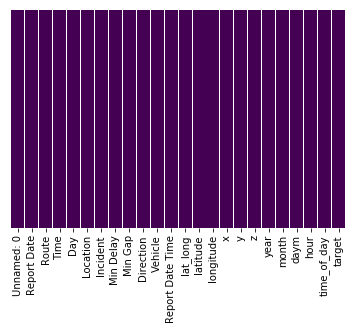

In [304]:
sns.heatmap(merged_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# Define test / training sets;  encode categorical values; process text field

In [305]:
# get training and test data set

train, test = train_test_split(merged_data, test_size = testproportion)
print("Through train test split. Test proportion:")
print(testproportion)



Through train test split. Test proportion:
0.01


# Define feature categories <a name='definecategories' />
<a href=#linkanchor>Back to link list</a>

In [306]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['Unnamed: 0', 'Report Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Direction', 'Vehicle', 'Report Date Time', 'lat_long', 'latitude', 'longitude', 'x', 'y', 'z', 'year', 'month', 'daym', 'hour', 'time_of_day', 'target']


In [307]:
# define the required column lists

textcols = [] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
if targetcontinuous:
    if sphereworld:
        continuouscols = ['x','y','z']
        excludefromcolist = ['latitude','longitude','Unnamed: 0','Location','lat_long','Report Date','Time','Report Date Time','Min Gap','target','time_of_day','Vehicle'] # columns to exclude completely from the model

    else:
        continuouscols = ['latitude','longitude'] # columns to deal with as continuous values - no embeddings
        excludefromcolist = ['Unnamed: 0','Location','lat_long','Report Date','Time','Report Date Time','Min Gap','target','time_of_day','Vehicle'] # columns to exclude completely from the model
else:
    # if target column is not renamed Min Delay put Min Delay in exclusion list
    if sphereworld:
        continuouscols = ['x','y','z']
        excludefromcolist = ['latitude','longitude','Unnamed: 0','Location','lat_long','Report Date','Time','Report Date Time','Min Gap','Min Delay','target','time_of_day','Vehicle'] # columns to exclude completely from the model
    else: 
        continuouscols = ['latitude','longitude'] # columns to deal with as continuous values - no embeddings
        excludefromcolist = ['Unnamed: 0','Location','lat_long','Report Date','Time','Report Date Time','Min Gap','Min Delay','target','time_of_day','Vehicle'] # columns to exclude completely from the model
# list(set(temp1) - set(temp2))
nontextcols = list(set(allcols) - set(textcols))
collist = list(set(nontextcols) - set(excludefromcolist) - set(continuouscols))

# print column list lengths and contents:
print("allcols",len(allcols))
print("excludefromcolist",len(excludefromcolist))
print(excludefromcolist)
print("textcols",len(textcols))
print(textcols)
print("continuouscols",len(continuouscols))
print(continuouscols)
print("collist",len(collist))
print(collist)

allcols 24
excludefromcolist 13
['latitude', 'longitude', 'Unnamed: 0', 'Location', 'lat_long', 'Report Date', 'Time', 'Report Date Time', 'Min Gap', 'Min Delay', 'target', 'time_of_day', 'Vehicle']
textcols 0
[]
continuouscols 3
['x', 'y', 'z']
collist 8
['month', 'Incident', 'hour', 'Direction', 'Day', 'Route', 'daym', 'year']


In [308]:
# ensure continuous columns have numeric type
for col in continuouscols:
    print("col is",col)
    merged_data[col] = merged_data[col].astype(float)
    print("got through one")
    

col is x
got through one
col is y
got through one
col is z
got through one


In [309]:
merged_data.dtypes

Unnamed: 0            int64
Report Date          object
Route                object
Time                 object
Day                  object
Location             object
Incident             object
Min Delay           float64
Min Gap             float64
Direction            object
Vehicle              object
Report Date Time     object
lat_long             object
latitude            float64
longitude           float64
x                   float64
y                   float64
z                   float64
year                  int64
month                 int64
daym                  int64
hour                  int64
time_of_day          object
target                int64
dtype: object

# Deal with missing values <a name='bookmark' />
<a href=#linkanchor>Back to link list</a>

In [310]:
# fill missing values

def fill_missing(dataset):
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)





In [311]:
# process categorical data
# replace values with category IDs in the categorical columns
# 


lelist = {}

for col in collist:
    le = LabelEncoder()
    if verboseout:
        print("processing ",col)
    # fit on superset to ensure encoding includes future data but only model on past data
    # np.hstack([superset_data[col]])
    le.fit(np.hstack([merged_data[col]]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    lelist[col] = le
    del le
    
    
train.head(5)
    

processing  month


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


processing  Incident
processing  hour
processing  Direction
processing  Day
processing  Route
processing  daym
processing  year


,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,...,longitude,x,y,z,year,month,daym,hour,time_of_day,target
41815,41815,2018-10-08 00:00:00,12,13:25:00,1,cne loop,8,5.0,10.0,3,...,-79.425881,0.957869,1.021327,1.058064,4,9,7,13,midday,1
15185,15185,2019-01-26 00:00:00,4,20:12:00,2,jarvis and queen,1,17.0,22.0,5,...,-79.373227,1.025216,0.982668,1.001580,5,0,25,20,wevening,1
69223,69223,2014-12-16 00:00:00,7,05:22:00,5,broadview and queen,6,15.0,30.0,2,...,-79.347697,1.055709,0.961398,0.984954,0,11,15,5,morning_rush,1
57080,57080,2017-12-05 00:00:00,4,06:34:00,5,russell yard,6,6.0,12.0,0,...,-79.322966,1.084172,0.939658,0.972858,3,11,4,6,morning_rush,1
59771,59771,2014-03-17 00:00:00,4,05:42:00,1,connaught ave and queen,6,5.0,8.0,2,...,-79.324295,1.083195,0.941310,0.969066,0,2,16,5,morning_rush,1


In [312]:
train['Incident'].head(10)

41815    8
15185    1
69223    6
57080    6
59771    6
27786    6
64958    6
31676    4
10536    3
8751     6
Name: Incident, dtype: int64

In [313]:
# part 1 of text processing
# tokenize list of text columns (made up of multiple strings)

from keras.preprocessing.text import Tokenizer

# text columns that we care about
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
# textcols = ['Resolution_Description', 'Subject']

for col in textcols:
    if verboseout:
        print("processing text col",col)
    
    # Tokenizer lower cases and removes punctuation by default
    tok_raw = Tokenizer(num_words=maxwords,lower=True)
    tok_raw.fit_on_texts(train[col])
    train[col] = tok_raw.texts_to_sequences(train[col])
    test[col] = tok_raw.texts_to_sequences(test[col])
    


In [314]:
train['Incident'].head(10)

41815    8
15185    1
69223    6
57080    6
59771    6
27786    6
64958    6
31676    4
10536    3
8751     6
Name: Incident, dtype: int64

In [315]:
# define max values for embeddings


max_dict = {}
textmax = 50

for col in collist:
    max_dict[col] = np.max([train[col].max(), test[col].max()])+1
    
# np.max([np.max(train['Resolution_Description'].max()), np.max(train['Subject'].max()),np.max(train['Other_Reason_for_Cancellation'].max()),np.max(train['Reason_for_Reopening'].max())])) 
for cols in textcols:
    maxtrain = np.max(train[(train[cols].map(len) != 0)][cols].map(max))
    maxtest = np.max(test[(test[cols].map(len) != 0)][cols].map(max))
    if verboseout:
        print("maxtrain.max()",maxtrain)
        print("maxtest .max()",maxtest)
    max_dict[cols] = max(maxtrain,maxtest)
    # max_dict[cols] = np.max([np.max(train[cols].max()), np.max(test[cols].max())])+20
    # np.max(df[(df['seq_item_description'].map(len) != 0)].seq_item_description.map(max))
    if max_dict[cols] > textmax:
        textmax = max_dict[cols]

if textmax < hctextmax:
    textmax = hctextmax
        
print("textmax",textmax)
                             
if verboseout:
    print("max_dict",max_dict)



textmax 7000
max_dict {'month': 12, 'Incident': 9, 'hour': 24, 'Direction': 6, 'Day': 7, 'Route': 15, 'daym': 31, 'year': 6}


In [316]:
train.head()

,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,...,longitude,x,y,z,year,month,daym,hour,time_of_day,target
41815,41815,2018-10-08 00:00:00,12,13:25:00,1,cne loop,8,5.0,10.0,3,...,-79.425881,0.957869,1.021327,1.058064,4,9,7,13,midday,1
15185,15185,2019-01-26 00:00:00,4,20:12:00,2,jarvis and queen,1,17.0,22.0,5,...,-79.373227,1.025216,0.982668,1.001580,5,0,25,20,wevening,1
69223,69223,2014-12-16 00:00:00,7,05:22:00,5,broadview and queen,6,15.0,30.0,2,...,-79.347697,1.055709,0.961398,0.984954,0,11,15,5,morning_rush,1
57080,57080,2017-12-05 00:00:00,4,06:34:00,5,russell yard,6,6.0,12.0,0,...,-79.322966,1.084172,0.939658,0.972858,3,11,4,6,morning_rush,1
59771,59771,2014-03-17 00:00:00,4,05:42:00,1,connaught ave and queen,6,5.0,8.0,2,...,-79.324295,1.083195,0.941310,0.969066,0,2,16,5,morning_rush,1


# Split training set into train / validate

In [317]:
# define and scale target and get validation sets

dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)

print(dtrain.shape)
print(dvalid.shape)
if verboseout:
    train["target"].head()

    




(51518, 24)
(12880, 24)


/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [318]:
# define keras variables
from keras.preprocessing.sequence import pad_sequences

# X for the features used

def get_keras_vars(dataset):
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

def get_keras_list_only(X_in):
    dictlist = []
    for key, value in X_in.items():
        print("X def loop key",key)
        print("value shape",value.shape)
        temp = [key,value]
        dictlist.append(value)
    return dictlist

def get_keras_np(X_in):
    return np.array(list(X_in.items()),dtype=object)
# np.array(list(result.items()), dtype=dtype)

# the deployment API for Watson Studio can only take a list/array, not a dictionary, so define list-only version for input
X_train, X_train_list = get_keras_vars(dtrain)
X_valid, X_valid_list = get_keras_vars(dvalid)
X_test,X_test_list = get_keras_vars(test)
print("keras variables defined")
print("X_train_list",X_train_list)





cat col is month
cat col is Incident
cat col is hour
cat col is Direction
cat col is Day
cat col is Route
cat col is daym
cat col is year
cont col is x
cont col is y
cont col is z
cat col is month
cat col is Incident
cat col is hour
cat col is Direction
cat col is Day
cat col is Route
cat col is daym
cat col is year
cont col is x
cont col is y
cont col is z
cat col is month
cat col is Incident
cat col is hour
cat col is Direction
cat col is Day
cat col is Route
cat col is daym
cat col is year
cont col is x
cont col is y
cont col is z
keras variables defined
X_train_list [array([9, 8, 1, ..., 3, 7, 7]), array([6, 5, 4, ..., 8, 6, 6]), array([20,  8, 11, ..., 16,  5,  6]), array([3, 3, 2, ..., 2, 3, 5]), array([2, 1, 4, ..., 2, 1, 5]), array([12, 11,  9, ..., 10, 12, 12]), array([26, 13, 25, ..., 24, 10, 24]), array([4, 1, 1, ..., 1, 0, 1]), array([0.98537625, 0.99737823, 1.07545677, ..., 0.95786898, 0.98818093,
       0.93438332]), array([1.01974216, 0.99913633, 0.95109137, ..., 1.02132

# Define and fit model <a name='modelfit' />
<a href=#linkanchor>Back to link list</a>

In [319]:
# define model in Keras

def get_model():
    
          
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    
      
    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # define layers for categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all 
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    
    # define layers for text columns
    if includetext:    
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col])) 
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")
        
    # define layers for continuous columns
    for col in continuouscols: 
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
    
    
              
    # build up layers
    # main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['Vehicle']) ),Dropout(dropout_rate) (Flatten() (embeddings['Direction']) )])
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings[collist[0]]) ),Dropout(dropout_rate) (Flatten() (embeddings[collist[1]]) )])
    for cols in collist:
        if (cols != collist[0]) & (cols != collist[1]):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])
    
    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])
                                                 
    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])
    
    print("main_l", main_l)                                            
    
       
    
    # define output layer
    output = Dense(1, activation=output_activation) (main_l)
   
    # define model        
                                                  
    model = Model(inputlayerlist, output)
    
       
    # define optimizer
    optimizer = SGD(lr=learning_rate)
   
    # compile model
    model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
         
    
    return model

    
model = get_model()

# output model summary

model.summary()
    

    

about to define embeddings
textmax is 7000
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_90/concat:0", shape=(?, ?), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Incident (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_65 (Embedding)        (None, 1, 10)        120         month[0][0]                      
__________________________________________________________________________________________________
embedding_66 (Embedding) 

In [320]:
BATCH_SIZE = 1000
# 200
epochs = 100
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",BATCH_SIZE)
print("epochs",epochs)
print("learning_rate",learning_rate)
print("loss function",loss_func)
print("output activation function",output_activation)


model = get_model()
modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid_list, dvalid.target), verbose=1)

text cols []
dropout  0.0003
L2 lambda  0.0003
batch size  1000
epochs 100
learning_rate 0.001
loss function binary_crossentropy
output activation function hard_sigmoid
about to define embeddings
textmax is 7000
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_100/concat:0", shape=(?, ?), dtype=float32)
Train on 51518 samples, validate on 12880 samples
Epoch 1/100
51518/51518 [==============================] - 8s 157us/step - loss: 0.7721 - acc: 0.4791 - weighted_acc: 0.4791 - val_loss: 0.7468 - val_acc: 0.4881 - val_weighted_acc: 0.4881
Epoch 2/100
51518/51518 [==============================] - 0s 9us/step - loss: 0.7050 - acc: 0.5346 - weighted_acc: 0.5346 - val_loss: 0.6941 - val_acc: 0.5540 - val_weighted_acc: 0.5540
Epoch 3/100
51518/51518 [==============================] - 1s 10us/step - loss: 0.6696 - acc: 0.5884 - weighted_acc: 0.5884 - val_loss: 0.6611 - val_acc: 0.5999 - val_weighted_acc: 0.5999
Epoch 4/100
51518/51518 [========

51518/51518 [==============================] - 1s 10us/step - loss: 0.5191 - acc: 0.7487 - weighted_acc: 0.7487 - val_loss: 0.5208 - val_acc: 0.7477 - val_weighted_acc: 0.7477
Epoch 43/100
51518/51518 [==============================] - 0s 10us/step - loss: 0.5179 - acc: 0.7498 - weighted_acc: 0.7498 - val_loss: 0.5198 - val_acc: 0.7484 - val_weighted_acc: 0.7484
Epoch 44/100
51518/51518 [==============================] - 1s 11us/step - loss: 0.5166 - acc: 0.7509 - weighted_acc: 0.7509 - val_loss: 0.5177 - val_acc: 0.7506 - val_weighted_acc: 0.7506
Epoch 45/100
51518/51518 [==============================] - 1s 10us/step - loss: 0.5149 - acc: 0.7522 - weighted_acc: 0.7522 - val_loss: 0.5160 - val_acc: 0.7509 - val_weighted_acc: 0.7509
Epoch 46/100
51518/51518 [==============================] - 1s 11us/step - loss: 0.5131 - acc: 0.7532 - weighted_acc: 0.7532 - val_loss: 0.5143 - val_acc: 0.7519 - val_weighted_acc: 0.7519
Epoch 47/100
51518/51518 [==============================] - 1s 11us/

51518/51518 [==============================] - 0s 9us/step - loss: 0.4999 - acc: 0.7630 - weighted_acc: 0.7630 - val_loss: 0.5149 - val_acc: 0.7554 - val_weighted_acc: 0.7554
Epoch 86/100
51518/51518 [==============================] - 0s 9us/step - loss: 0.5062 - acc: 0.7596 - weighted_acc: 0.7596 - val_loss: 0.5094 - val_acc: 0.7572 - val_weighted_acc: 0.7572
Epoch 87/100
51518/51518 [==============================] - 0s 9us/step - loss: 0.5042 - acc: 0.7606 - weighted_acc: 0.7606 - val_loss: 0.5057 - val_acc: 0.7585 - val_weighted_acc: 0.7585
Epoch 88/100
51518/51518 [==============================] - 0s 9us/step - loss: 0.5028 - acc: 0.7612 - weighted_acc: 0.7612 - val_loss: 0.5036 - val_acc: 0.7604 - val_weighted_acc: 0.7604
Epoch 89/100
51518/51518 [==============================] - 1s 10us/step - loss: 0.5014 - acc: 0.7619 - weighted_acc: 0.7619 - val_loss: 0.5026 - val_acc: 0.7609 - val_weighted_acc: 0.7609
Epoch 90/100
51518/51518 [==============================] - 0s 9us/step 

In [321]:
modifier = "jun15"
savepath = path
if savemodel == True:
    model_json = model.to_json()
    with open(savepath+'model'+modifier+'.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(savepath+'dmweights'+modifier+'.h5')
    
    # save tokenizer tok_raw for text and label encoder for categorical cols
    if len(textcols) > 0:
        with open(savepath+'tokenizer'+modifier+'.pickle', 'wb') as handle:
            pickle.dump(tok_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(savepath+'le'+modifier+'.pickle', 'wb') as handle2:
        pickle.dump(lelist, handle2, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved model, weights, tokenizer and label encoder to disk")
      
    model.save(savepath+'dmmodel'+modifier+'.h5')
    print("Saved model, weights, tokenizer and label encoder to disk")


Saved model, weights, tokenizer and label encoder to disk
Saved model, weights, tokenizer and label encoder to disk


# Load saved model and weights <a name='reload' />
<a href=#linkanchor>Back to link list</a>

In [322]:
from keras.models import load_model
new_model = load_model(savepath+'dmmodel'+modifier+'.h5')

In [323]:
if presaved == True:
    BATCH_SIZE = 200
    epochs = 1
    modelfit2 = new_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid, dvalid.target),class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

In [324]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
Incident (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_73 (Embedding)        (None, 1, 10)        120         month[0][0]                      
__________________________________________________________________________________________________
embedding_74 (Embedding)        (None, 1, 10)        90          Incident[0][0]                   
__________________________________________________________________________________________________
hour (Inpu

# Predictions and renderings

In [325]:
# predictions on training set

preds = model.predict(X_train, batch_size=BATCH_SIZE)

In [326]:
len(lelist)

8

In [327]:
preds.shape

(51518, 1)

In [328]:
preds[:50]

array([[0.78626573],
       [0.47634214],
       [0.87424123],
       [0.6529996 ],
       [0.8361643 ],
       [0.7944332 ],
       [0.565145  ],
       [0.71678287],
       [0.7275506 ],
       [0.86059856],
       [0.58148915],
       [0.77731526],
       [0.8803632 ],
       [0.7625445 ],
       [0.62543774],
       [0.91749966],
       [0.7891932 ],
       [0.88175654],
       [0.6682243 ],
       [0.82320905],
       [0.5471028 ],
       [0.7022418 ],
       [0.58101773],
       [0.6372981 ],
       [0.8156264 ],
       [0.71413434],
       [0.7750101 ],
       [0.8134055 ],
       [0.7214169 ],
       [0.68923706],
       [0.9068115 ],
       [0.57049507],
       [0.9046061 ],
       [0.515522  ],
       [0.6243814 ],
       [0.5036649 ],
       [0.7784105 ],
       [0.7943181 ],
       [0.7991042 ],
       [0.8041941 ],
       [0.91905296],
       [0.6836299 ],
       [0.8013593 ],
       [0.7438573 ],
       [0.6988962 ],
       [0.7368968 ],
       [0.43161026],
       [0.736

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


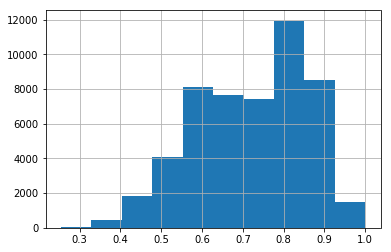

In [329]:
dtrain["predict"] = preds
dtrain.predict[:5]
if verboseout:
    dtrain.predict.hist()

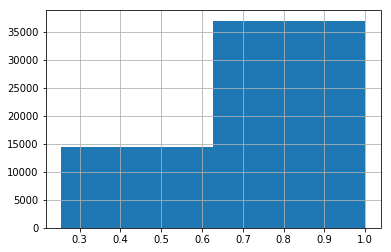

In [330]:
if verboseout:
    dtrain.predict.hist(bins=2)

In [331]:
# print(type(apar_ds['Time_to_relief'].iloc[0]))
print(type(preds))
print(preds.shape)
print(type(dtrain.target))

<class 'numpy.ndarray'>
(51518, 1)
<class 'pandas.core.series.Series'>


In [332]:
# get rounded predictions 
dtrain["predround"] = preds.round().astype(int)
dtrain.predround[:5]

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


42487    1
26097    0
19789    1
25631    1
10224    1
Name: predround, dtype: int64

In [333]:
dtrain.groupby('predround').count()

,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,...,x,y,z,year,month,daym,hour,time_of_day,target,predict
predround,,,,,,,,,,,,,,,,,,,,,
0,3142,3142,3142,3142,3142,3142,3142,3142,3142,3142,...,3142,3142,3142,3142,3142,3142,3142,3142,3142,3142
1,48376,48376,48376,48376,48376,48376,48376,48376,48376,48376,...,48376,48376,48376,48376,48376,48376,48376,48376,48376,48376


In [334]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dtrain.target[:100000] - dtrain.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct train")
print((len(deltatr) - deltatr.sum())/len(deltatr))



12022
percentage correct train
0.76664466788307


In [335]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid, batch_size=BATCH_SIZE)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


652      0.832479
42468    0.837791
53445    0.800875
42819    0.856109
31781    0.549803
Name: predict, dtype: float32

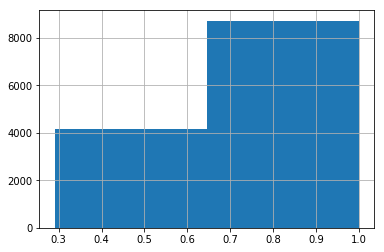

In [336]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [337]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


652      0
42468    0
53445    0
42819    0
31781    1
6907     1
17576    0
7538     0
804      0
18653    0
Name: deltaval, dtype: int64
3022


In [338]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,...,z,year,month,daym,hour,time_of_day,target,predround,predict,deltaval
31781,31781,2018-02-20 00:00:00,7,21:13:00,5,dufferin and king,6,4.0,8.0,5,...,1.047116,4,1,19,21,evening,0,1,0.549803,1
6907,6907,2016-07-05 00:00:00,7,09:41:00,5,church and king,4,4.0,8.0,5,...,1.003314,2,6,4,9,morning_rush,0,1,0.608682,1
3373,3373,2016-03-31 00:00:00,7,05:19:00,4,roncesvalles yard,5,3.0,6.0,5,...,1.023267,2,2,30,5,morning_rush,0,1,0.504578,1
22747,22747,2015-05-31 00:00:00,8,17:30:00,3,broadview and dundas,6,4.0,8.0,5,...,0.975894,1,4,30,17,waft_rush,0,1,0.872823,1
39391,39391,2018-08-10 00:00:00,11,15:33:00,0,college and spadina,4,12.0,21.0,3,...,0.989150,4,7,9,15,aft_rush,1,0,0.491359,1
869,869,2016-01-23 00:00:00,12,06:19:00,2,roncesvalles yard,3,4.0,9.0,2,...,1.023267,2,0,22,6,wmorning_rush,0,1,0.763818,1
36133,36133,2018-06-01 00:00:00,7,16:30:00,0,missing,2,4.0,8.0,2,...,1.002997,4,5,0,16,aft_rush,0,1,0.542695,1
17489,17489,2015-01-13 00:00:00,10,05:34:00,5,russell yard,5,20.0,25.0,2,...,0.972858,1,0,12,5,morning_rush,1,0,0.473906,1
40562,40562,2018-09-06 00:00:00,10,01:48:00,4,fleet and lakeshore,6,1.0,1.0,2,...,1.054331,4,8,5,1,overnight,0,1,0.602853,1
22021,22021,2015-05-06 00:00:00,11,11:45:00,6,charollete loop,4,2.0,4.0,3,...,1.022699,1,4,5,11,midday,0,1,0.617417,1


In [339]:
dvalidright.head(20)

,Unnamed: 0,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,...,z,year,month,daym,hour,time_of_day,target,predround,predict,deltaval
652,652,2016-01-18 00:00:00,4,08:05:00,1,humber loop,3,5.0,10.0,2,...,1.068633,2,0,17,8,morning_rush,1,1,0.832479,0
42468,42468,2018-10-27 00:00:00,9,12:15:00,2,h. park,6,6.0,12.0,2,...,0.989834,4,9,26,12,wmidday,1,1,0.837791,0
53445,53445,2017-08-22 00:00:00,8,16:03:00,5,dundas and jarvis,6,6.0,12.0,2,...,0.991767,3,7,21,16,aft_rush,1,1,0.800875,0
42819,42819,2018-11-03 00:00:00,4,08:12:00,2,russell yd,6,10.0,20.0,2,...,1.002997,4,10,2,8,wmorning_rush,1,1,0.856109,0
17576,17576,2015-01-13 00:00:00,9,18:38:00,5,high park loop,6,10.0,15.0,2,...,1.018858,1,0,12,18,aft_rush,1,1,0.771785,0
7538,7538,2016-07-25 00:00:00,13,05:48:00,1,stclair station,5,4.0,8.0,2,...,0.911077,2,6,24,5,morning_rush,0,0,0.447431,0
804,804,2016-01-21 00:00:00,11,09:53:00,4,college and spadina,1,61.0,67.0,3,...,0.989150,2,0,20,9,morning_rush,1,1,0.550968,0
18653,18653,2015-02-07 00:00:00,7,09:31:00,2,broadview and queen,5,6.0,13.0,2,...,0.984954,1,1,6,9,wmorning_rush,1,1,0.586018,0
50666,50666,2017-06-01 00:00:00,12,16:28:00,4,bathurst station,6,6.0,12.0,4,...,0.965393,3,5,0,16,aft_rush,1,1,0.782939,0
14950,14950,2019-01-22 00:00:00,9,12:22:00,5,carlton and church,6,68.0,73.0,2,...,0.977315,5,0,21,12,midday,1,1,0.789481,0


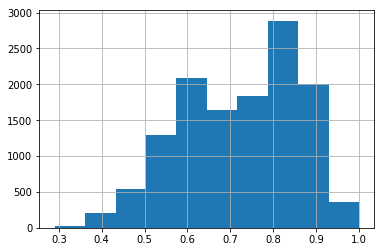

In [340]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

In [341]:
dtrain.target[:50]

42487    1
26097    0
19789    1
25631    1
10224    1
67977    1
32343    1
3039     1
45268    0
36711    1
39737    1
32177    1
13648    0
37472    0
52741    1
58112    1
5593     0
47657    1
48496    0
28963    1
25878    0
10385    1
32616    0
41762    1
10440    1
45057    1
9849     1
35223    0
69107    0
36769    1
58567    1
36225    1
49541    1
63510    0
2164     0
7741     0
27673    1
25012    1
11482    1
56125    1
27358    1
54091    0
434      1
2656     1
33068    0
17447    1
4533     0
34174    1
36595    1
61953    1
Name: target, dtype: int64

In [342]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


3022
percentage correct validate
0.7653726708074534


dict_keys(['val_loss', 'val_acc', 'val_weighted_acc', 'loss', 'acc', 'weighted_acc'])


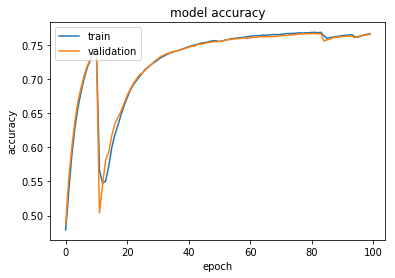

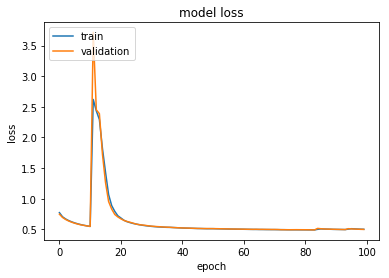

In [343]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
plt.plot(modelfit.history['acc'])
plt.plot(modelfit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

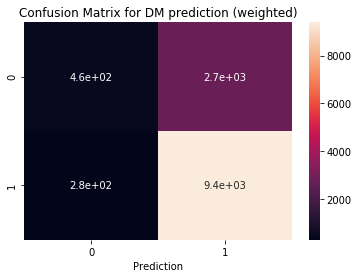

In [344]:
from sklearn import metrics

cfmap=metrics.confusion_matrix(y_true=dvalid['target'],  # True labels
                         y_pred=dvalid["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for DM prediction (weighted)")
plt.show()

In [345]:
model.metrics_names

['loss', 'acc', 'weighted_acc']

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at IBM Canada.

Copyright © IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.